In [2]:
# ============================================================
# 1. IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, label_binarize
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    log_loss,
    matthews_corrcoef,
    cohen_kappa_score,
    classification_report,
    ConfusionMatrixDisplay,
)

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import shap
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")


/Users/anidamod/DS/accident_severity_ml_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ============================================================
# 2. LOAD DATA (ACCIDENT + VEHICLE)
# ============================================================

ACCIDENTS_PATH = "Accident_Information.csv"
VEHICLES_PATH  = "Vehicle_Information.csv"

acc = pd.read_csv(
    ACCIDENTS_PATH,
    parse_dates=["Date"],
    low_memory=False
)

veh = pd.read_csv(
    VEHICLES_PATH,
    encoding='latin-1',  # Use latin-1 encoding to handle special characters
    low_memory=False
)

print("Accidents shape:", acc.shape)
print("Vehicles shape:", veh.shape)
acc.head()

Accidents shape: (2047256, 34)
Vehicles shape: (2177205, 24)


,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,NaN,2005-01-04,Tuesday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,NaN,2005-01-05,Wednesday,1.0,...,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,NaN,2005-01-06,Thursday,1.0,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,NaN,2005-01-07,Friday,1.0,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,NaN,2005-01-10,Monday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,21:13,Urban,Fine no high winds,2005,No


In [4]:
# ============================================================
# 3. BASIC CLEANING & TARGET SETUP
# ============================================================

# If dataset already has Severity_Class, use it; else create from Accident_Severity
if "Severity_Class" in acc.columns:
    target_col = "Severity_Class"
else:
    # assuming Accident_Severity is categorical with 'Slight','Serious','Fatal'
    mapping = {"Slight": 0, "Serious": 1, "Fatal": 2}
    acc["Severity_Class"] = acc["Accident_Severity"].map(mapping).astype("int8")
    target_col = "Severity_Class"

print(acc[target_col].value_counts())


Severity_Class
0    1734548
1     286339
2      26369
Name: count, dtype: int64


In [5]:
# ============================================================
# 4. TIME-BASED FEATURE ENGINEERING
# ============================================================

def extract_hour(t):
    try:
        return int(str(t).split(":")[0])
    except Exception:
        return -1

acc["Year"]  = acc["Date"].dt.year
acc["Month"] = acc["Date"].dt.month
acc["Day"]   = acc["Date"].dt.day
acc["Hour"]  = acc["Time"].apply(extract_hour)

# Weekend flag (assuming 1=Sunday or 1=Monday doesn't matter much – just "weekend or not")
# If Day_of_Week already numeric 1–7, adjust if needed.
if acc["Day_of_Week"].dtype != "O":
    acc["Is_Weekend"] = acc["Day_of_Week"].isin([6, 7]).astype(int)
else:
    # if it's string like 'Monday', 'Saturday', etc.
    acc["Is_Weekend"] = acc["Day_of_Week"].isin(["Saturday", "Sunday"]).astype(int)

acc[["Date", "Hour", "Is_Weekend"]].head()


,Date,Hour,Is_Weekend
0,2005-01-04,17,0
1,2005-01-05,17,0
2,2005-01-06,0,0
3,2005-01-07,10,0
4,2005-01-10,21,0


In [6]:
# ============================================================
# 5. VEHICLE-LEVEL FEATURE ENGINEERING  (AGGREGATED TO ACCIDENT)
#    (lightweight, safe for laptop but still useful)
# ============================================================

# convert to numeric where possible
veh["Age_of_Vehicle"] = pd.to_numeric(veh["Age_of_Vehicle"], errors="coerce")
veh["Engine_Capacity_.CC."] = pd.to_numeric(veh["Engine_Capacity_.CC."], errors="coerce")

veh_agg = veh.groupby("Accident_Index").agg({
    "Vehicle_Reference": "count",
    "Age_of_Vehicle": "mean",
    "Engine_Capacity_.CC.": "mean"
}).rename(columns={
    "Vehicle_Reference": "veh_count",
    "Age_of_Vehicle": "veh_age_mean",
    "Engine_Capacity_.CC.": "engine_mean"
})

acc = acc.merge(veh_agg, on="Accident_Index", how="left")

# fill missing vehicle info (e.g., single-vehicle accidents not in veh file)
acc["veh_count"]    = acc["veh_count"].fillna(0)
acc["veh_age_mean"] = acc["veh_age_mean"].fillna(-1)
acc["engine_mean"]  = acc["engine_mean"].fillna(-1)

acc[["Accident_Index", "veh_count", "veh_age_mean", "engine_mean"]].head()


,Accident_Index,veh_count,veh_age_mean,engine_mean
0,200501BS00001,0.0,-1.0,-1.0
1,200501BS00002,1.0,3.0,8268.0
2,200501BS00003,1.0,5.0,8300.0
3,200501BS00004,1.0,4.0,1769.0
4,200501BS00005,1.0,10.0,85.0


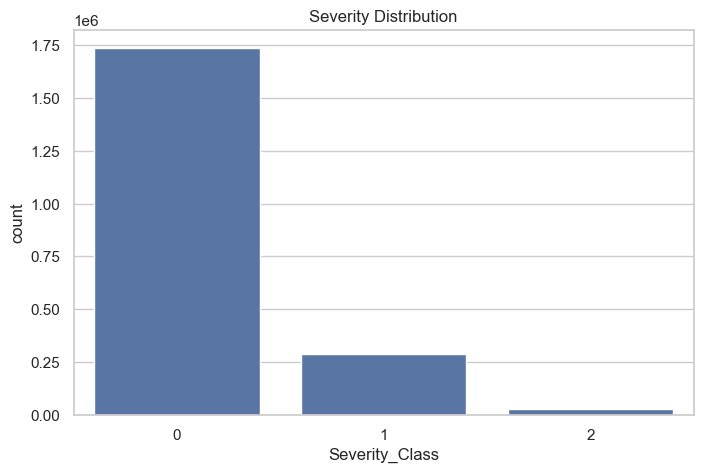

Severity_Class
0    0.847255
1    0.139865
2    0.012880
Name: proportion, dtype: float64


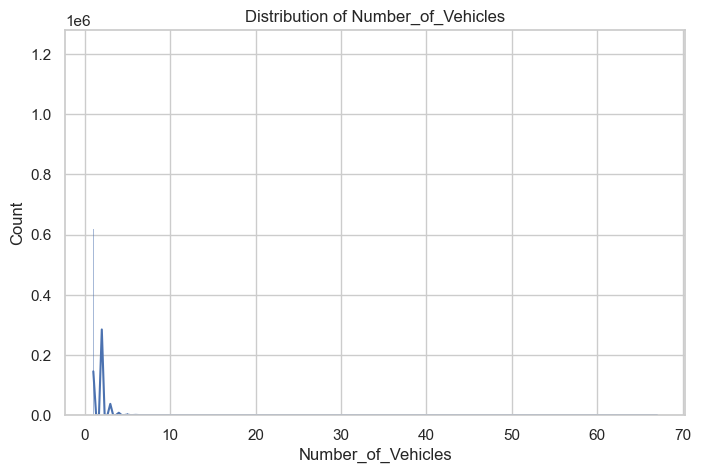

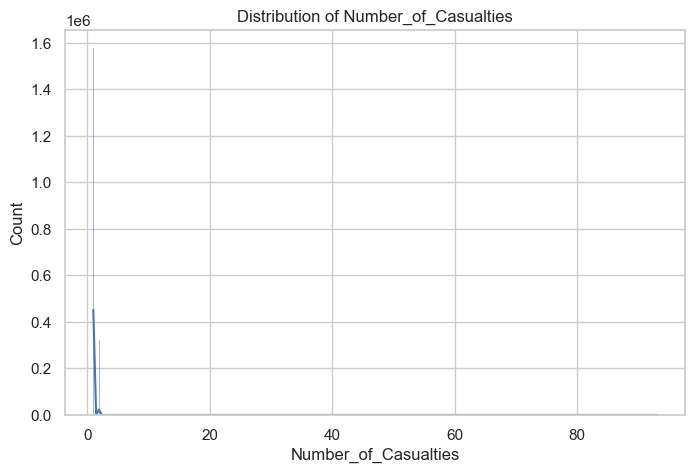

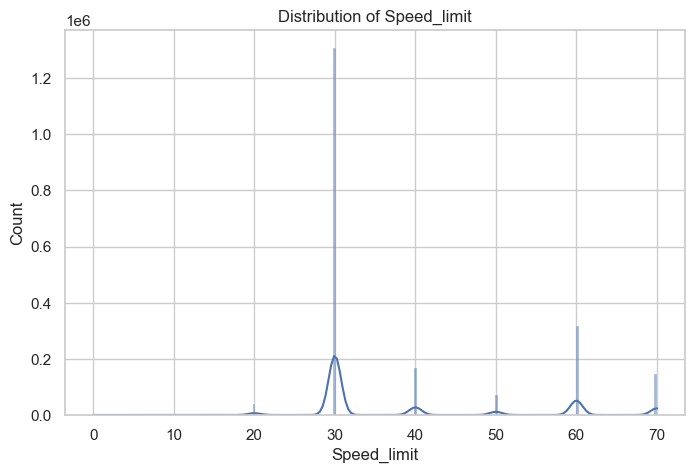

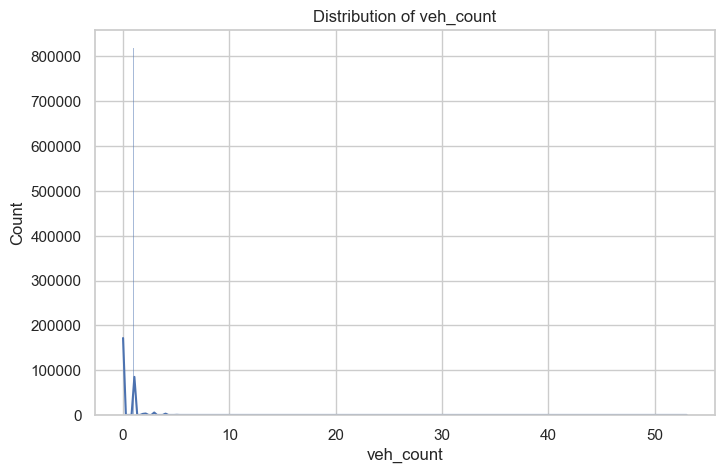

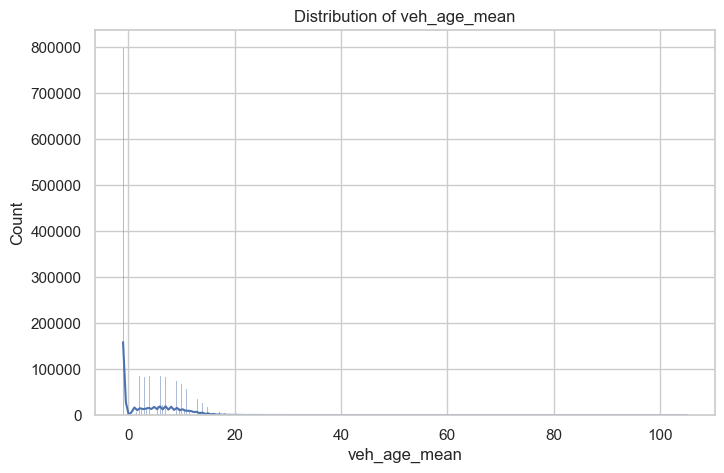

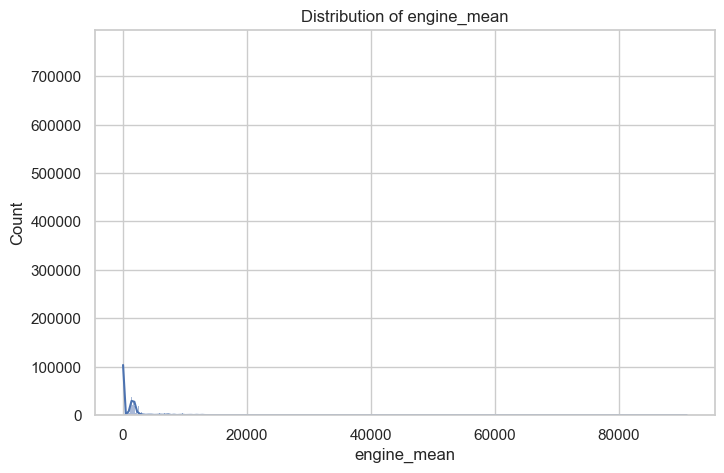

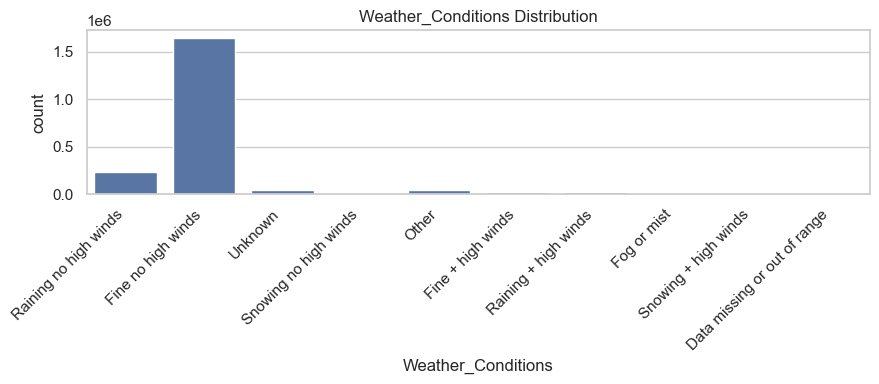

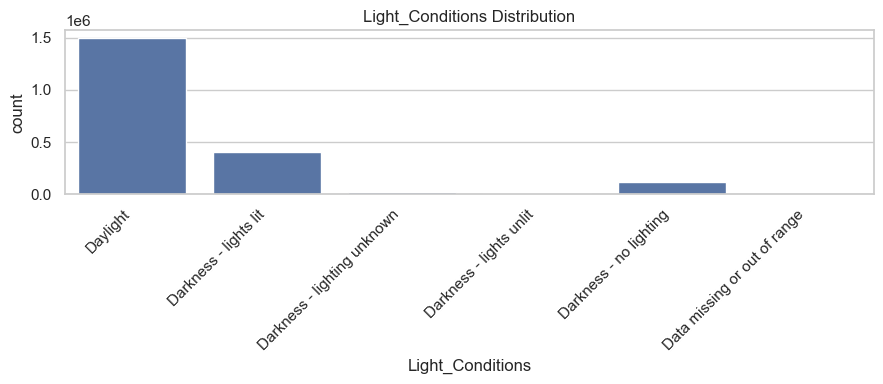

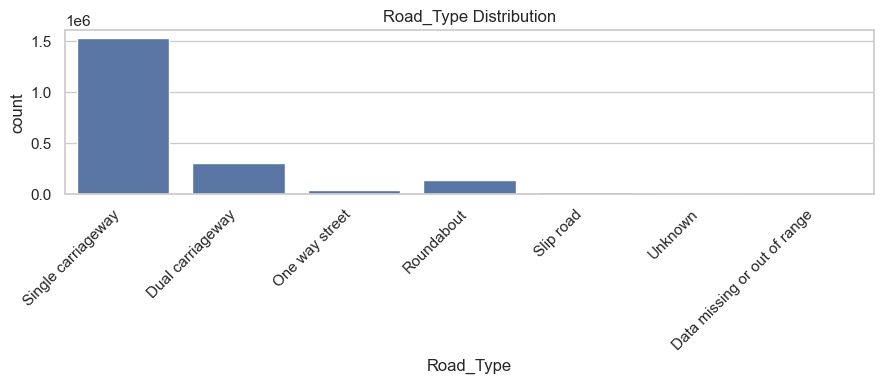

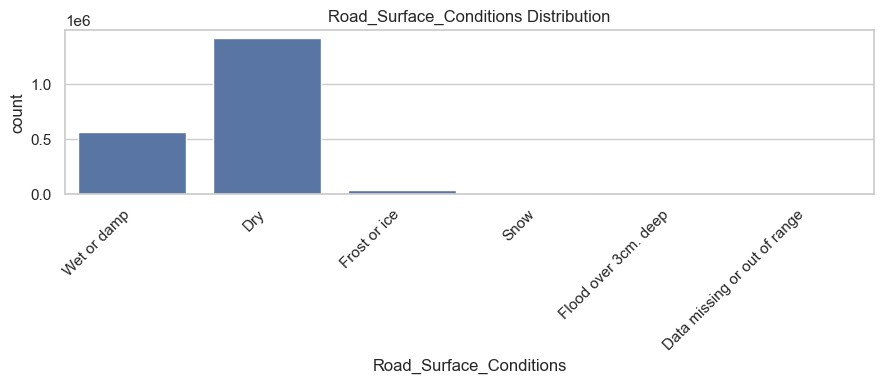

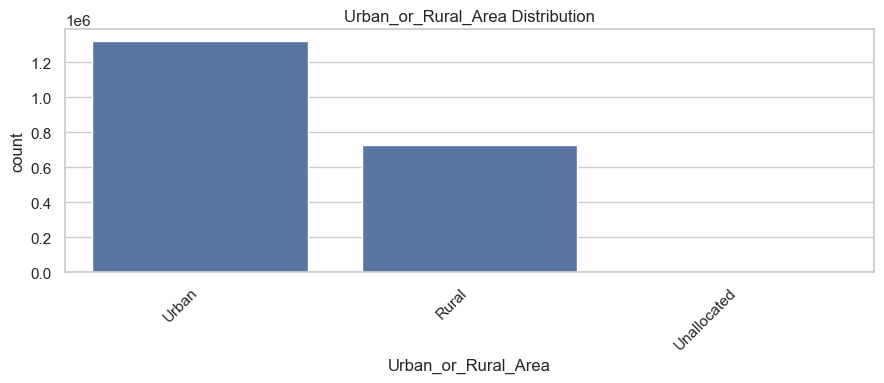

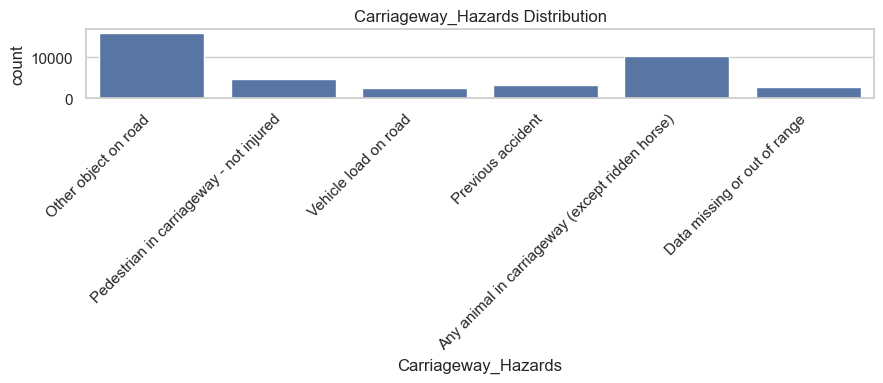

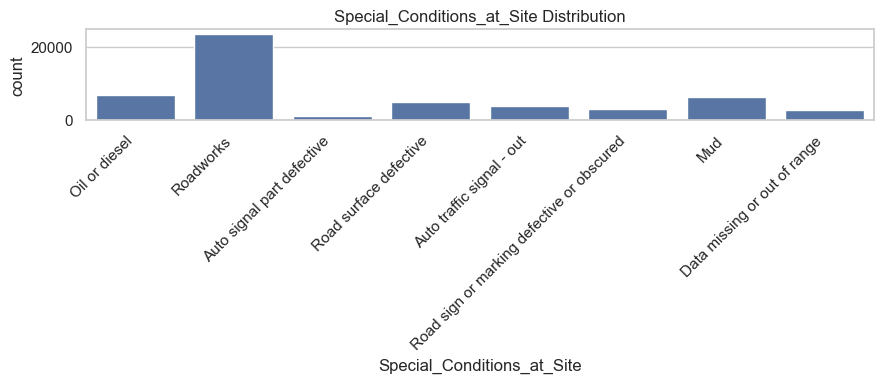

In [7]:
# ============================================================
# 6. IMPORTANT UNIVARIATE EDA
#    (only plots that help with modelling intuition)
# ============================================================

# 6.1 Target distribution
plt.figure()
sns.countplot(data=acc, x=target_col)
plt.title("Severity Distribution")
plt.show()
print(acc[target_col].value_counts(normalize=True))

# 6.2 Key numeric features
num_eda_cols = ["Number_of_Vehicles", "Number_of_Casualties",
                "Speed_limit", "veh_count", "veh_age_mean", "engine_mean"]

for col in num_eda_cols:
    plt.figure()
    sns.histplot(acc[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# 6.3 Key categorical features
cat_eda_cols = [
    "Weather_Conditions",
    "Light_Conditions",
    "Road_Type",
    "Road_Surface_Conditions",
    "Urban_or_Rural_Area",
    "Carriageway_Hazards",
    "Special_Conditions_at_Site"
]

for col in cat_eda_cols:
    if col in acc.columns:
        plt.figure(figsize=(9,4))
        sns.countplot(data=acc, x=col)
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{col} Distribution")
        plt.tight_layout()
        plt.show()


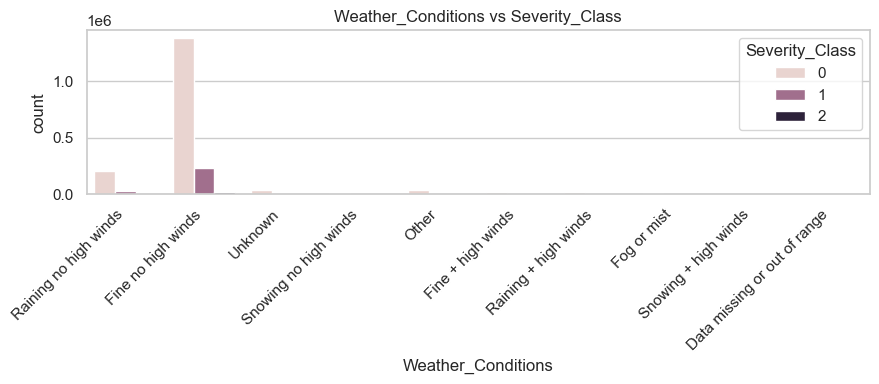

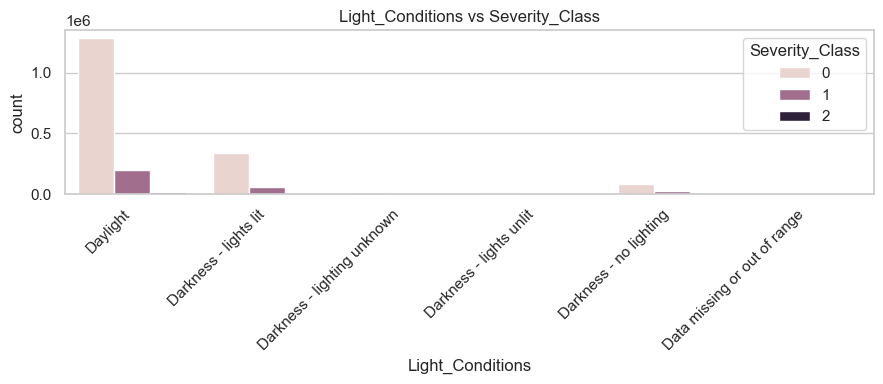

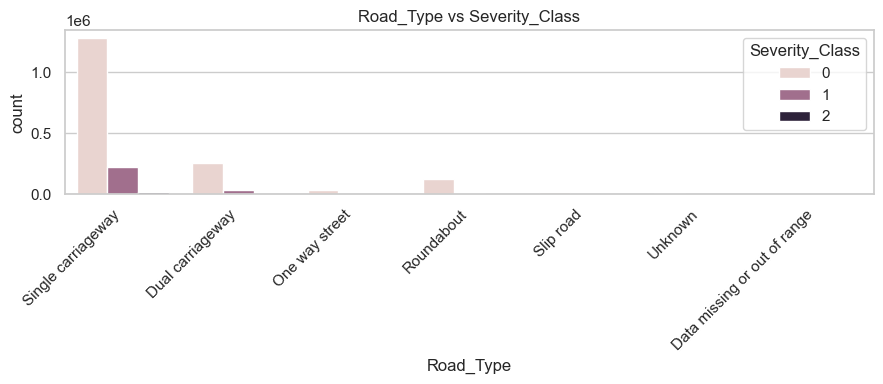

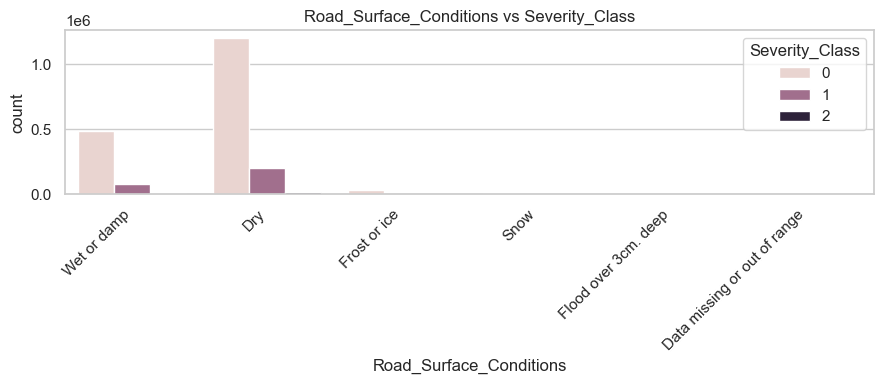

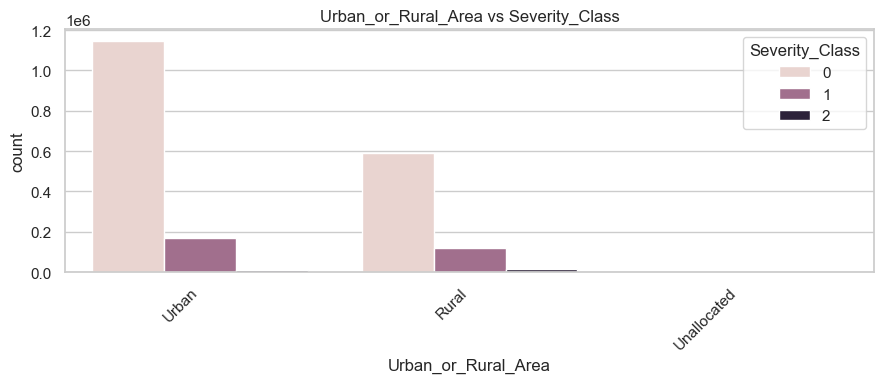

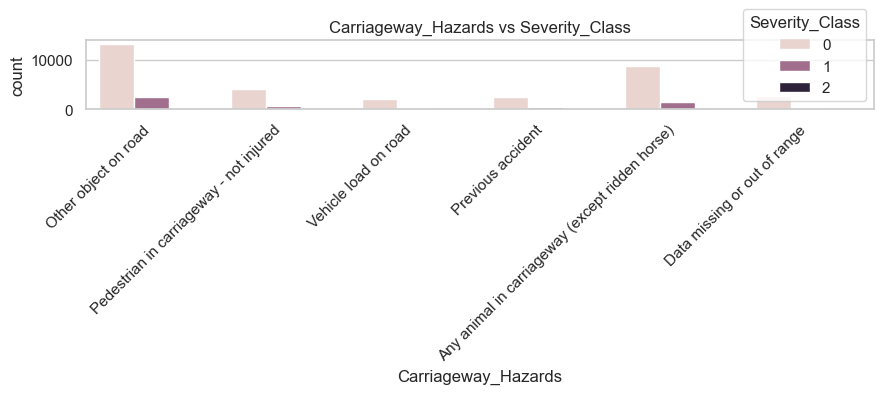

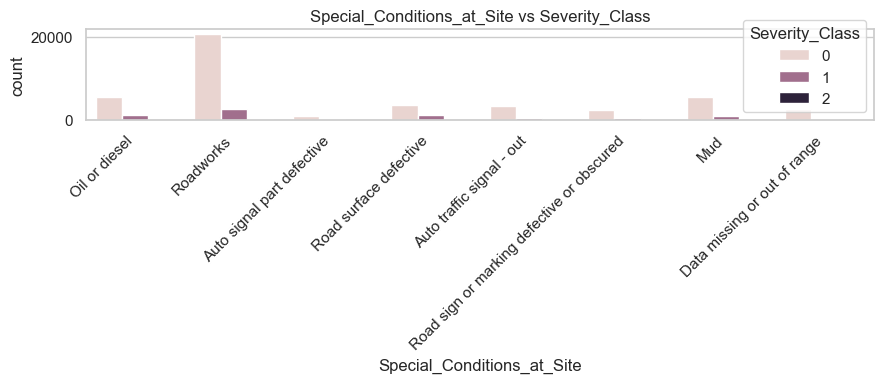

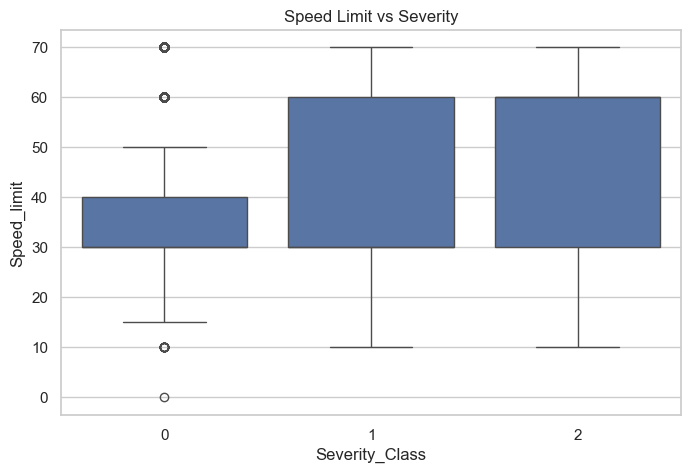

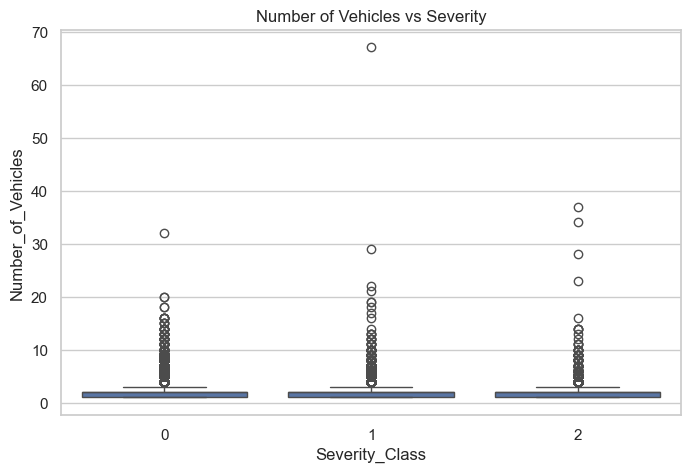

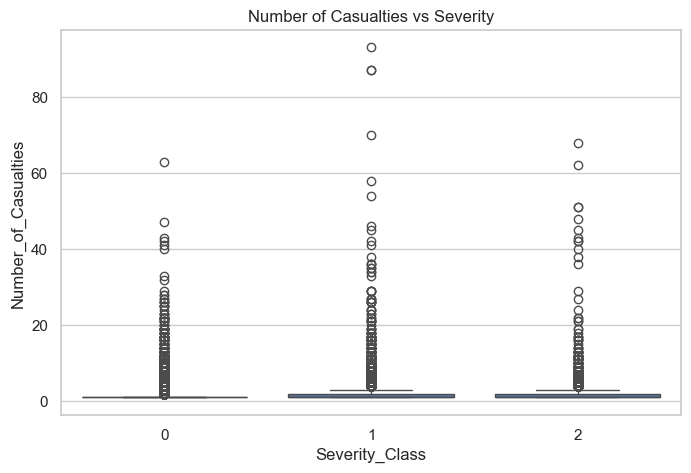

In [8]:
# ============================================================
# 7. IMPORTANT BIVARIATE EDA (Severity vs key factors)
# ============================================================

# helper to plot countplots with Severity hue
def plot_severity_vs(col):
    if col in acc.columns:
        plt.figure(figsize=(9,4))
        sns.countplot(data=acc, x=col, hue=target_col)
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{col} vs {target_col}")
        plt.tight_layout()
        plt.show()

for col in ["Weather_Conditions", "Light_Conditions", "Road_Type",
            "Road_Surface_Conditions", "Urban_or_Rural_Area",
            "Carriageway_Hazards", "Special_Conditions_at_Site"]:
    plot_severity_vs(col)

# Boxplots: severity vs numeric variables
plt.figure()
sns.boxplot(data=acc, x=target_col, y="Speed_limit")
plt.title("Speed Limit vs Severity")
plt.show()

plt.figure()
sns.boxplot(data=acc, x=target_col, y="Number_of_Vehicles")
plt.title("Number of Vehicles vs Severity")
plt.show()

plt.figure()
sns.boxplot(data=acc, x=target_col, y="Number_of_Casualties")
plt.title("Number of Casualties vs Severity")
plt.show()


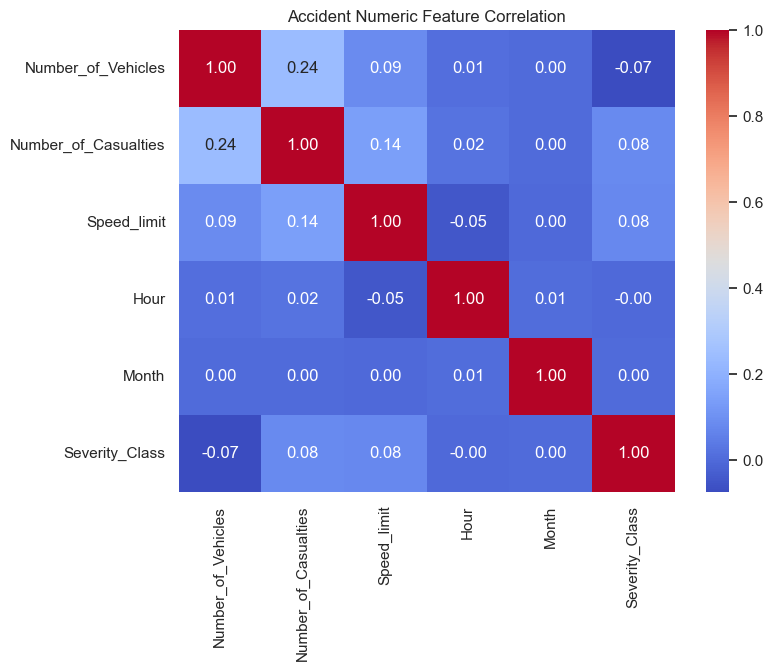

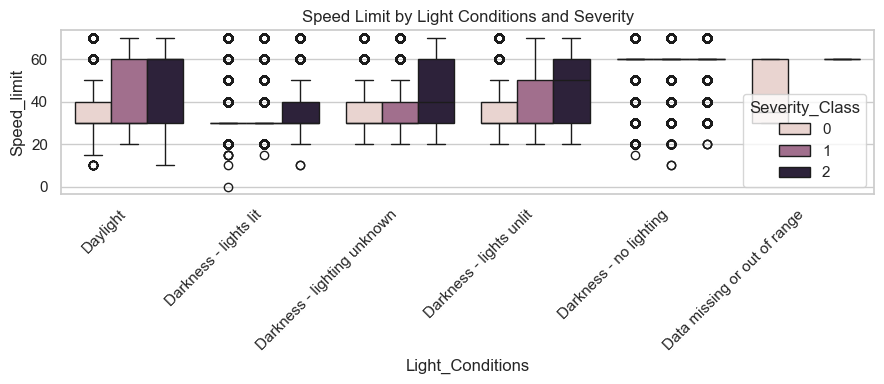

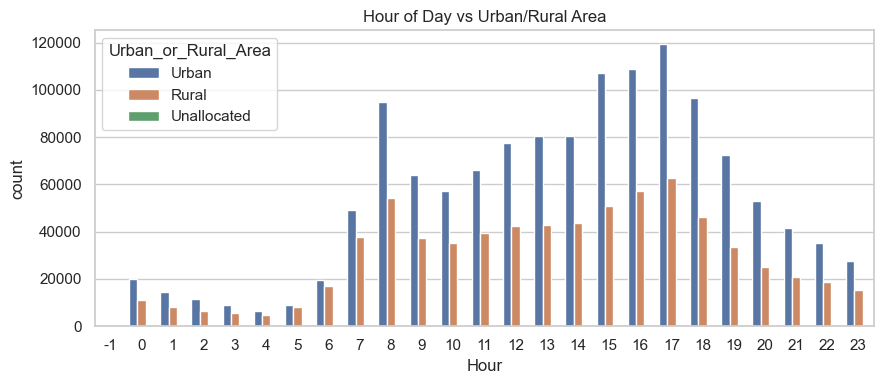

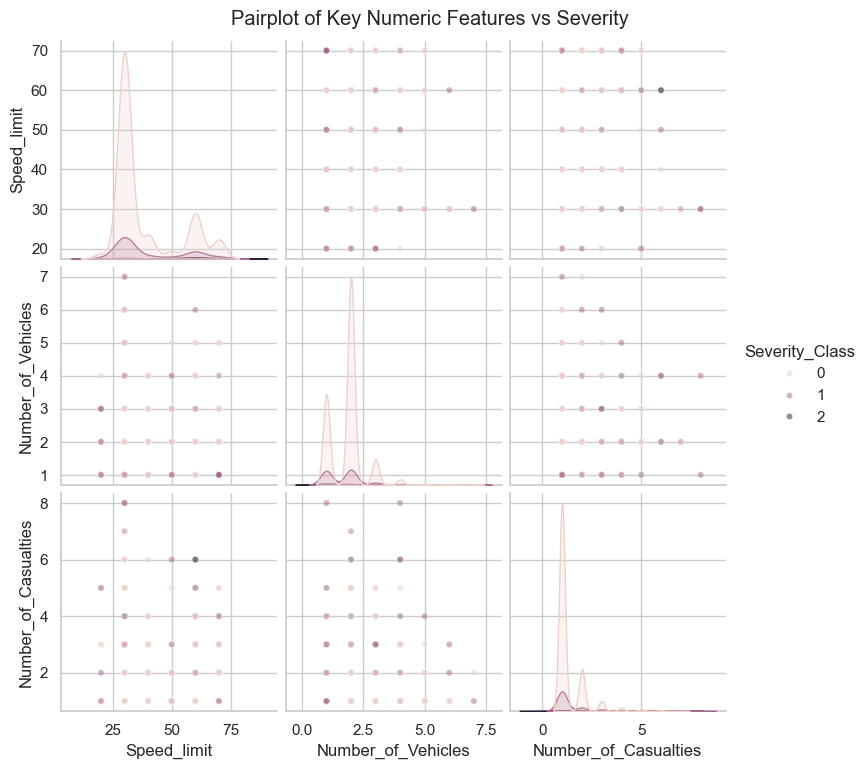

In [9]:
# ============================================================
# 8. MULTIVARIATE EDA (ONLY A FEW USEFUL ONES)
# ============================================================

# 8.1 Numeric correlation heatmap
sel_numeric = ["Number_of_Vehicles", "Number_of_Casualties",
               "Speed_limit", "Hour", "Month", target_col]

plt.figure(figsize=(8,6))
sns.heatmap(acc[sel_numeric].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Accident Numeric Feature Correlation")
plt.show()

# 8.2 Speed vs Light Conditions vs Severity
if "Light_Conditions" in acc.columns:
    plt.figure(figsize=(9,4))
    sns.boxplot(data=acc, x="Light_Conditions", y="Speed_limit", hue=target_col)
    plt.xticks(rotation=45, ha="right")
    plt.title("Speed Limit by Light Conditions and Severity")
    plt.tight_layout()
    plt.show()

# 8.3 Hour vs Urban/Rural
if "Urban_or_Rural_Area" in acc.columns:
    plt.figure(figsize=(9,4))
    sns.countplot(data=acc, x="Hour", hue="Urban_or_Rural_Area")
    plt.title("Hour of Day vs Urban/Rural Area")
    plt.tight_layout()
    plt.show()

# 8.4 Pairplot (small sample to keep it light)
sample_pair = acc[[target_col, "Speed_limit",
                   "Number_of_Vehicles", "Number_of_Casualties"]].dropna().sample(3000, random_state=42)

sns.pairplot(sample_pair,
             vars=["Speed_limit", "Number_of_Vehicles", "Number_of_Casualties"],
             hue=target_col, diag_kind="kde", plot_kws={"alpha":0.5, "s":20})
plt.suptitle("Pairplot of Key Numeric Features vs Severity", y=1.02)
plt.show()


In [10]:
# ============================================================
# 9. PREP DATA FOR MODELLING
#     - select feature columns that EDA showed important
# ============================================================

feature_cols = [
    # accident numeric
    "Number_of_Vehicles",
    "Number_of_Casualties",
    "Speed_limit",
    "Hour",
    "Month",
    "Is_Weekend",
    "veh_count",
    "veh_age_mean",
    "engine_mean",
    "Latitude",
    "Longitude",
    # accident categorical
    "Weather_Conditions",
    "Light_Conditions",
    "Road_Type",
    "Road_Surface_Conditions",
    "Urban_or_Rural_Area",
    "Junction_Detail",
    "Junction_Control",
    "Carriageway_Hazards",
    "Special_Conditions_at_Site",
]

# keep only columns that actually exist
feature_cols = [c for c in feature_cols if c in acc.columns]

data = acc[feature_cols + [target_col]].copy()
print("Total rows before dropping NA:", data.shape)
data = data.dropna(subset=[target_col])
print("Rows after dropping rows with missing target:", data.shape)

X_full = data[feature_cols]
y_full = data[target_col]


Total rows before dropping NA: (2047256, 21)
Rows after dropping rows with missing target: (2047256, 21)


In [11]:
# ============================================================
# 10. HANDLE MISSING VALUES & CATEGORICAL TYPES
# ============================================================

# identify categorical & numeric features
cat_features = X_full.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = [c for c in feature_cols if c not in cat_features]

# fill numerics with median, categoricals with 'Unknown'
for col in num_features:
    X_full[col] = pd.to_numeric(X_full[col], errors="coerce")
    X_full[col] = X_full[col].fillna(X_full[col].median())

for col in cat_features:
    X_full[col] = X_full[col].astype("category")
    # Only add "Unknown" if it's not already in categories
    if "Unknown" not in X_full[col].cat.categories:
        X_full[col] = X_full[col].cat.add_categories(["Unknown"])
    X_full[col] = X_full[col].fillna("Unknown")

X_full.dtypes

Number_of_Vehicles               int64
Number_of_Casualties             int64
Speed_limit                    float64
Hour                             int64
Month                            int32
Is_Weekend                       int64
veh_count                      float64
veh_age_mean                   float64
engine_mean                    float64
Latitude                       float64
Longitude                      float64
Weather_Conditions            category
Light_Conditions              category
Road_Type                     category
Road_Surface_Conditions       category
Urban_or_Rural_Area           category
Junction_Detail               category
Junction_Control              category
Carriageway_Hazards           category
Special_Conditions_at_Site    category
dtype: object

In [12]:
# ============================================================
# 11. STRATIFIED SAMPLE (300k) TO TRAIN ON LAPTOP
# ============================================================

N = 300_000
if len(X_full) > N:
    X_sample, _, y_sample, _ = train_test_split(
        X_full, y_full,
        train_size=N,
        stratify=y_full,
        random_state=42
    )
else:
    X_sample, y_sample = X_full, y_full

print("Sampled data shape:", X_sample.shape)
print("Sampled severity distribution:")
print(y_sample.value_counts())


Sampled data shape: (300000, 20)
Sampled severity distribution:
Severity_Class
0    254177
1     41959
2      3864
Name: count, dtype: int64


In [13]:
# ============================================================
# 12. TRAIN/TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_sample,
    y_sample,
    test_size=0.2,
    stratify=y_sample,
    random_state=42
)

X_train.shape, X_test.shape


((240000, 20), (60000, 20))

In [14]:
# ============================================================
# 13. ENCODING FOR MODELS
#     - RF/XGB: OrdinalEncoder
#     - LGBM/CatBoost: use categories directly
# ============================================================

# 13.1 Ordinal encoding for RF and XGB
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()

if cat_features:
    X_train_enc[cat_features] = encoder.fit_transform(X_train[cat_features])
    X_test_enc[cat_features]  = encoder.transform(X_test[cat_features])

X_train_enc.head()


,Number_of_Vehicles,Number_of_Casualties,Speed_limit,Hour,Month,Is_Weekend,veh_count,veh_age_mean,engine_mean,Latitude,Longitude,Weather_Conditions,Light_Conditions,Road_Type,Road_Surface_Conditions,Urban_or_Rural_Area,Junction_Detail,Junction_Control,Carriageway_Hazards,Special_Conditions_at_Site
40471,2,1,30.0,7,10,0,0.0,-1.0,-1.0,53.456676,-2.261862,2.0,5.0,4.0,1.0,2.0,5.0,3.0,2.0,8.0
1004984,2,1,60.0,13,10,0,1.0,6.0,2477.0,51.575217,0.330369,2.0,5.0,4.0,5.0,0.0,4.0,4.0,5.0,8.0
719674,2,1,30.0,10,7,0,0.0,-1.0,-1.0,50.736168,-1.784855,2.0,5.0,4.0,1.0,2.0,0.0,1.0,5.0,8.0
1377187,2,1,30.0,13,10,0,1.0,26.0,498.0,51.606565,-0.090611,2.0,5.0,4.0,1.0,2.0,9.0,3.0,5.0,8.0
202092,1,1,30.0,2,7,0,1.0,3.0,7300.0,51.514573,-0.129916,2.0,1.0,4.0,1.0,2.0,4.0,2.0,5.0,8.0


In [15]:
# 13.2 Category dtype for LightGBM & CatBoost
X_train_lgb = X_train.copy()
X_test_lgb  = X_test.copy()
for col in cat_features:
    X_train_lgb[col] = X_train_lgb[col].astype("category")
    X_test_lgb[col]  = X_test_lgb[col].astype("category")


In [16]:
# ============================================================
# 14. CLASS WEIGHTS FOR IMBALANCE
# ============================================================

class_counts = y_train.value_counts().to_dict()
num_classes = len(class_counts)
total = len(y_train)
class_weights = {cls: total / (num_classes * cnt)
                 for cls, cnt in class_counts.items()}
class_weights


{0: 0.3934258539799943, 1: 2.3832931152620134, 2: 25.88159171789065}

In [17]:
# ============================================================
# 15. TRAIN MODELS (RF, XGB, LGBM, CatBoost)
# ============================================================

results = {}
all_preds = {}
all_proba = {}

# 15.1 Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    class_weight=class_weights,
    random_state=42
)
rf.fit(X_train_enc, y_train)
y_pred_rf = rf.predict(X_test_enc)
y_proba_rf = rf.predict_proba(X_test_enc)

all_preds["RandomForest"] = y_pred_rf
all_proba["RandomForest"] = y_proba_rf
results["RandomForest"] = f1_score(y_test, y_pred_rf, average="macro")
print("Random Forest Macro F1:", results["RandomForest"])


Random Forest Macro F1: 0.30818088177946584


In [18]:
# 15.2 XGBoost
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42
)

xgb_model.fit(X_train_enc, y_train)
y_proba_xgb = xgb_model.predict_proba(X_test_enc)
y_pred_xgb  = np.argmax(y_proba_xgb, axis=1)

all_preds["XGBoost"] = y_pred_xgb
all_proba["XGBoost"] = y_proba_xgb
results["XGBoost"] = f1_score(y_test, y_pred_xgb, average="macro")
print("XGBoost Macro F1:", results["XGBoost"])


XGBoost Macro F1: 0.32186646454367235


In [19]:
# 15.3 LightGBM
sample_weights = y_train.map(class_weights).values

lgb_train = lgb.Dataset(
    X_train_lgb,
    label=y_train,
    weight=sample_weights,
    categorical_feature=cat_features or None
)
lgb_valid = lgb.Dataset(
    X_test_lgb,
    label=y_test,
    categorical_feature=cat_features or None
)

params_lgb = {
    "objective": "multiclass",
    "num_class": 3,
    "learning_rate": 0.05,
    "num_leaves": 31,
    "metric": "multi_logloss",
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "seed": 42,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100),
]

lgb_model = lgb.train(
    params_lgb,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    num_boost_round=1000,
    callbacks=callbacks
)

y_proba_lgb = lgb_model.predict(X_test_lgb)
y_pred_lgb  = np.argmax(y_proba_lgb, axis=1)

all_preds["LightGBM"] = y_pred_lgb
all_proba["LightGBM"] = y_proba_lgb
results["LightGBM"] = f1_score(y_test, y_pred_lgb, average="macro")
print("LightGBM Macro F1:", results["LightGBM"])


Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.904695	valid's multi_logloss: 0.927372
[100]	train's multi_logloss: 0.904695	valid's multi_logloss: 0.927372
[200]	train's multi_logloss: 0.856602	valid's multi_logloss: 0.905284
[200]	train's multi_logloss: 0.856602	valid's multi_logloss: 0.905284
[300]	train's multi_logloss: 0.818027	valid's multi_logloss: 0.88767
[300]	train's multi_logloss: 0.818027	valid's multi_logloss: 0.88767
[400]	train's multi_logloss: 0.784073	valid's multi_logloss: 0.871411
[400]	train's multi_logloss: 0.784073	valid's multi_logloss: 0.871411
[500]	train's multi_logloss: 0.755363	valid's multi_logloss: 0.857056
[500]	train's multi_logloss: 0.755363	valid's multi_logloss: 0.857056
[600]	train's multi_logloss: 0.728922	valid's multi_logloss: 0.844627
[600]	train's multi_logloss: 0.728922	valid's multi_logloss: 0.844627
[700]	train's multi_logloss: 0.705675	valid's multi_logloss: 0.832299
[700]	train's multi_logloss: 0.

In [20]:
# 15.4 CatBoost
cat_indices = [X_train.columns.get_loc(c) for c in cat_features]

cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    random_seed=42,
    verbose=False
)

cb_model.fit(X_train, y_train,
             cat_features=cat_indices,
             eval_set=(X_test, y_test),
             verbose=False)

y_proba_cb = cb_model.predict_proba(X_test)
y_pred_cb  = cb_model.predict(X_test).astype(int).ravel()

all_preds["CatBoost"] = y_pred_cb
all_proba["CatBoost"] = y_proba_cb
results["CatBoost"] = f1_score(y_test, y_pred_cb, average="macro")
print("CatBoost Macro F1:", results["CatBoost"])


CatBoost Macro F1: 0.31307061102473305


In [21]:
# ============================================================
# 16. METRICS COMPARISON TABLE
# ============================================================

metrics_table = []

for name in all_preds.keys():
    y_pred  = all_preds[name]
    proba   = all_proba[name]

    metrics_table.append({
        "Model": name,
        "Macro_F1": f1_score(y_test, y_pred, average="macro"),
        "Weighted_F1": f1_score(y_test, y_pred, average="weighted"),
        "Micro_F1": f1_score(y_test, y_pred, average="micro"),
        "Accuracy": accuracy_score(y_test, y_pred),
        "LogLoss": log_loss(y_test, proba),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "Cohen_Kappa": cohen_kappa_score(y_test, y_pred),
    })

metrics_df = pd.DataFrame(metrics_table).set_index("Model")
metrics_df


,Macro_F1,Weighted_F1,Micro_F1,Accuracy,LogLoss,MCC,Cohen_Kappa
Model,,,,,,,
RandomForest,0.308181,0.777836,0.846367,0.846367,0.493890,0.018000,0.003855
XGBoost,0.321866,0.782394,0.846300,0.846300,0.443032,0.071184,0.028437
LightGBM,0.379159,0.679826,0.615967,0.615967,0.801047,0.161023,0.135664
CatBoost,0.313071,0.780450,0.847450,0.847450,0.439988,0.062589,0.017252


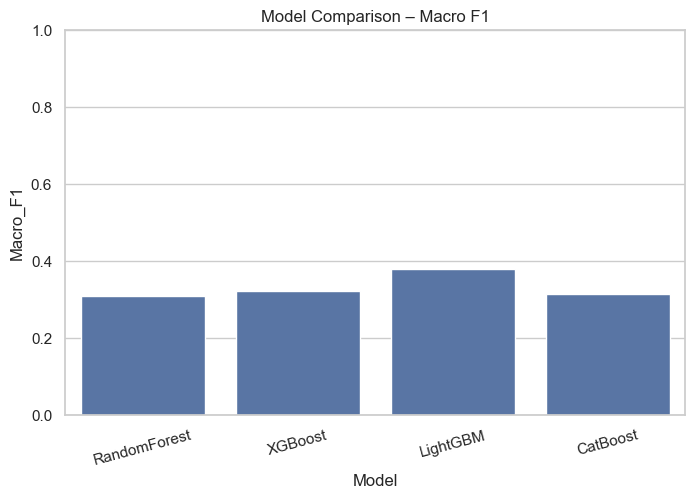

In [22]:
plt.figure()
sns.barplot(x=metrics_df.index, y=metrics_df["Macro_F1"])
plt.ylim(0, 1)
plt.title("Model Comparison – Macro F1")
plt.xticks(rotation=15)
plt.show()


Best model by Macro F1: LightGBM


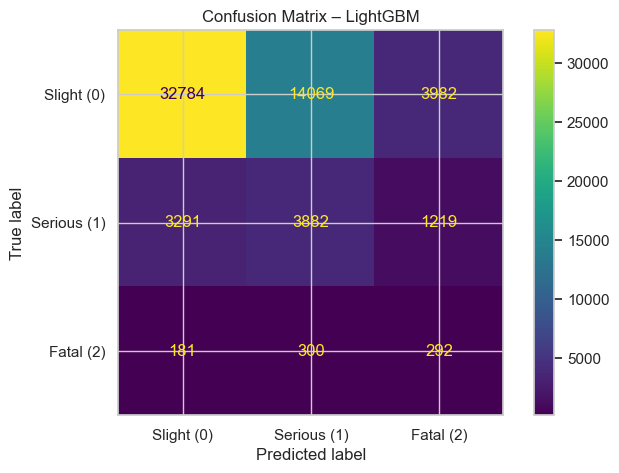

              precision    recall  f1-score   support

           0       0.90      0.64      0.75     50835
           1       0.21      0.46      0.29      8392
           2       0.05      0.38      0.09       773

    accuracy                           0.62     60000
   macro avg       0.39      0.50      0.38     60000
weighted avg       0.80      0.62      0.68     60000



In [23]:
# ============================================================
# 17. CONFUSION MATRIX & CLASSIFICATION REPORT FOR BEST MODEL
# ============================================================

best_model_name = metrics_df["Macro_F1"].idxmax()
print("Best model by Macro F1:", best_model_name)

y_best = all_preds[best_model_name]

ConfusionMatrixDisplay.from_predictions(
    y_test, y_best,
    display_labels=["Slight (0)", "Serious (1)", "Fatal (2)"]
)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

print(classification_report(y_test, y_best))


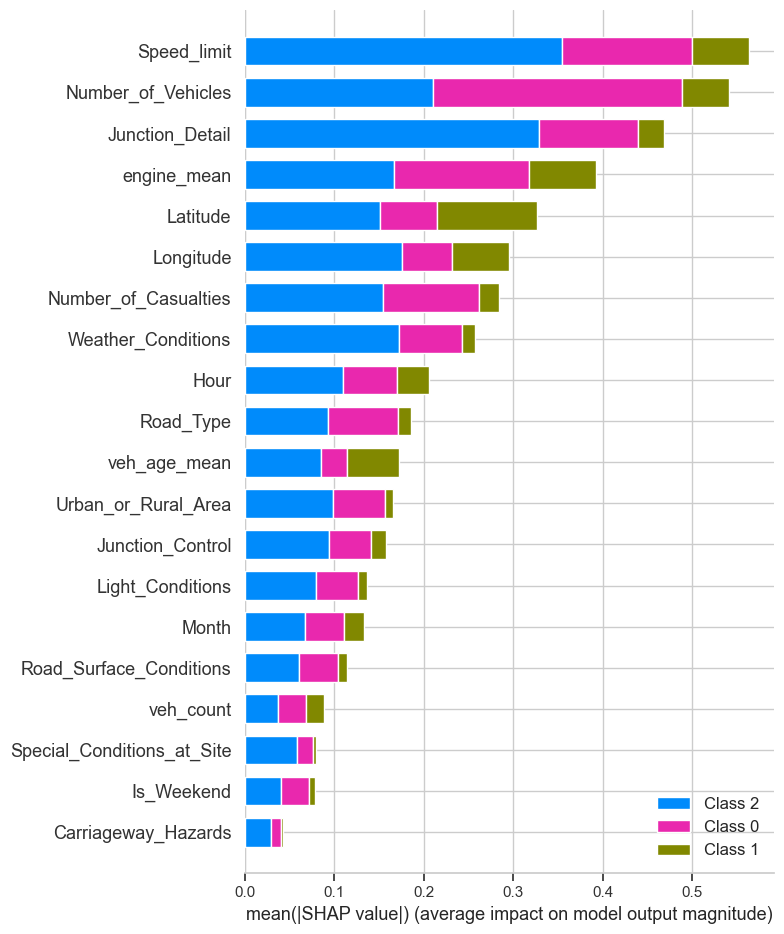

In [24]:
# ============================================================
# 18. SHAP EXPLAINABILITY FOR LIGHTGBM (GLOBAL + PER-CLASS)
# ============================================================

# Use a subset for SHAP speed
X_shap = X_test_lgb.sample(min(5000, len(X_test_lgb)), random_state=42)

shap.initjs()
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer(X_shap)

# Global importance (all classes combined)
shap.summary_plot(shap_values.values, X_shap, plot_type="bar")


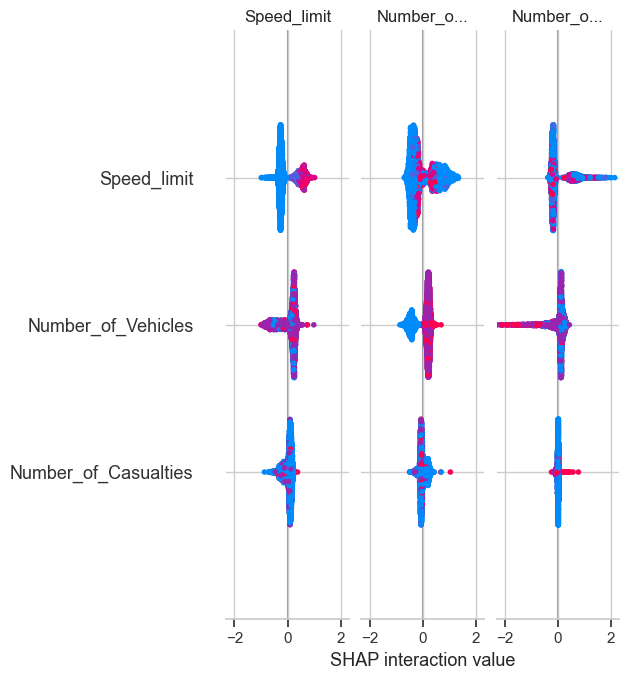

In [25]:
# Full beeswarm
shap.summary_plot(shap_values.values, X_shap)


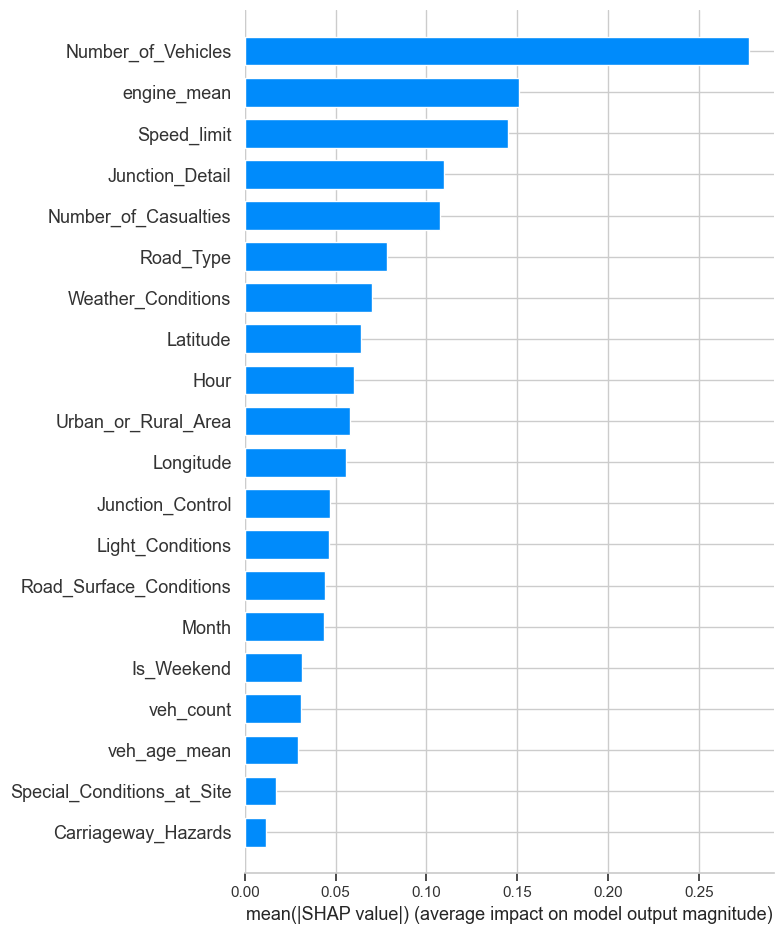

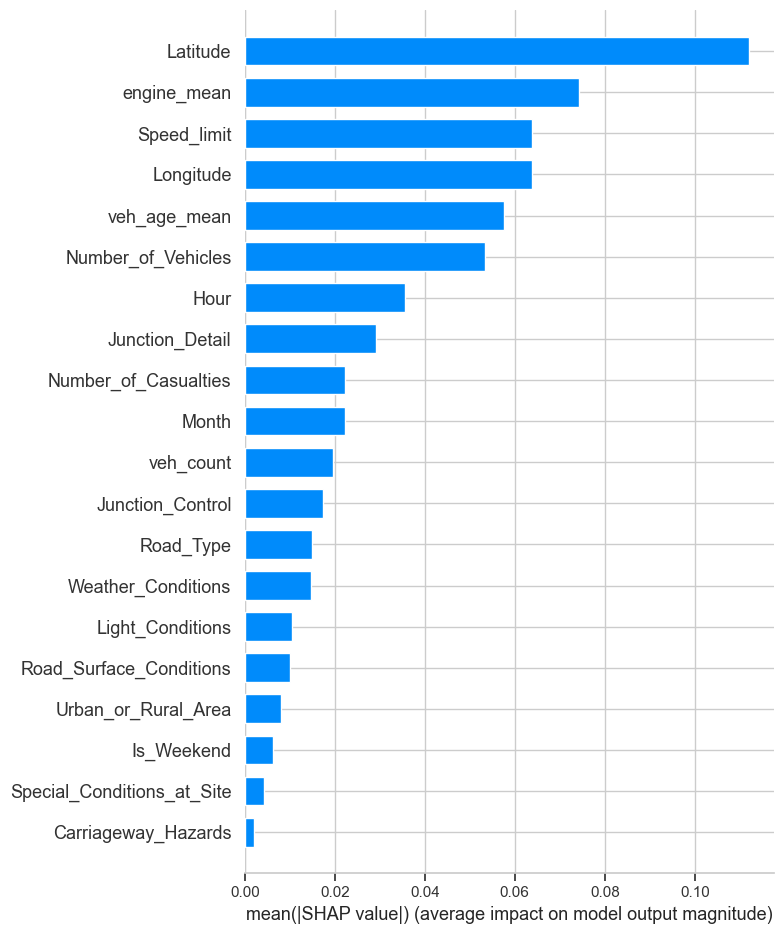

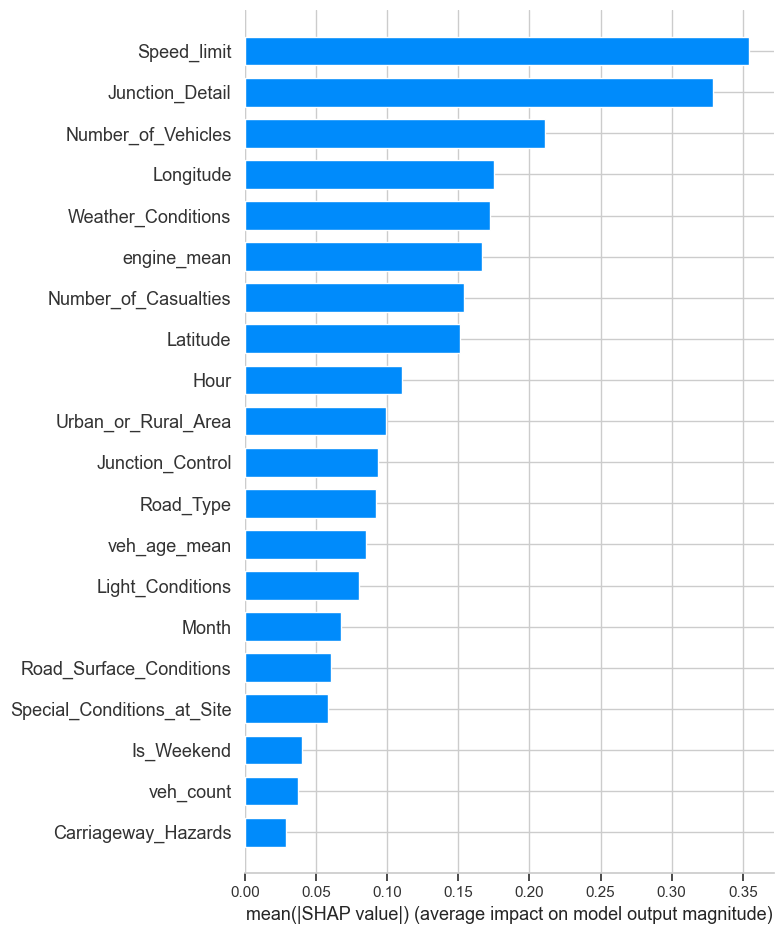

In [26]:
# Class-specific importance: 0=Slight, 1=Serious, 2=Fatal
for cls in range(3):
    shap.summary_plot(
        shap_values.values[:, :, cls],
        X_shap,
        plot_type="bar",
        show=True
    )


In [27]:
acc["Longitude"].value_counts()

Longitude
-0.977611    71
-1.871043    57
-3.310596    48
-1.234393    47
-0.173445    47
             ..
-1.972082     1
-2.057665     1
-1.931755     1
-1.991843     1
-3.272073     1
Name: count, Length: 1417728, dtype: int64

In [28]:
import geopandas as gpd
from shapely.geometry import Point

# Drop rows without coordinates
acc_geo = acc.dropna(subset=["Latitude", "Longitude", "Severity_Class"]).copy()

# Optional: sample for speed/visual clarity
acc_geo_sample = acc_geo.sample(50_000, random_state=42)  # adjust 50k as you like

# Create geometry column from lon/lat
geometry = [Point(xy) for xy in zip(acc_geo_sample["Longitude"], acc_geo_sample["Latitude"])]

# GeoDataFrame with WGS84 (EPSG:4326)
gdf_acc = gpd.GeoDataFrame(
    acc_geo_sample,
    geometry=geometry,
    crs="EPSG:4326"
)
gdf_acc.head()


,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,InScotland,Severity_Class,Month,Day,Hour,Is_Weekend,veh_count,veh_age_mean,engine_mean,geometry
767768,200904DA09047,Unclassified,0.0,NaN,0.0,Serious,NaN,2009-04-04,Saturday,1.0,...,No,1,4,4,23,1,1.0,4.0,1399.0,POINT (-2.69981 53.75819)
1595976,201443W128044,Unclassified,7117.0,NaN,0.0,Serious,NaN,2014-04-21,Monday,2.0,...,No,1,4,21,6,0,1.0,13.0,1796.0,POINT (-1.26883 51.4283)
783540,2009100119609,A,191.0,NaN,0.0,Slight,NaN,2009-02-16,Monday,1.0,...,No,0,2,16,14,0,3.0,5.0,1895.5,POINT (-1.65352 55.00367)
391434,200701EO40983,C,0.0,Unclassified,0.0,Slight,NaN,2007-12-23,Sunday,1.0,...,No,0,12,23,0,1,2.0,6.5,2549.5,POINT (-0.13335 51.52578)
1237005,201204CJ12160,A,5209.0,NaN,0.0,Slight,NaN,2012-08-23,Thursday,1.0,...,No,0,8,23,8,0,1.0,5.0,1796.0,POINT (-2.80758 53.58659)


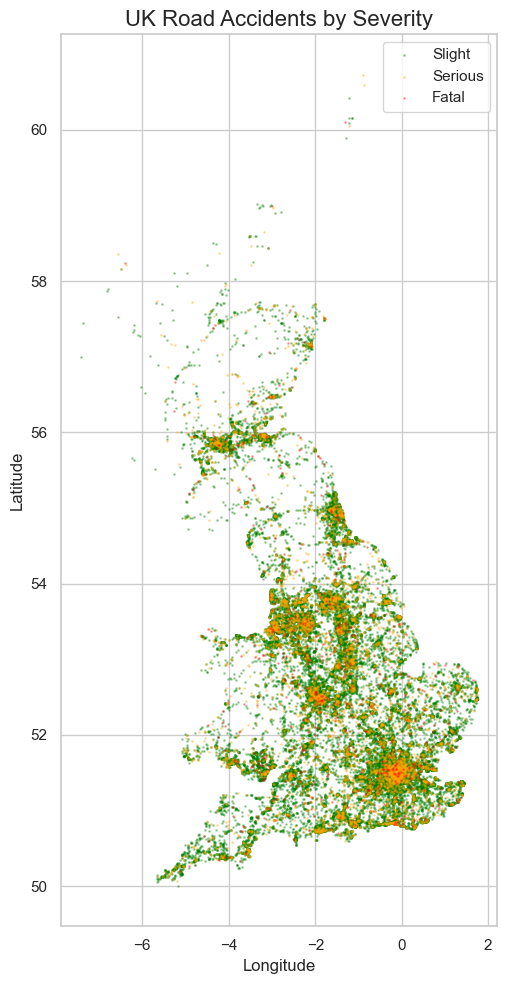

Plotted 50,000 accidents


In [30]:
# Simple plot of accidents without basemap
fig, ax = plt.subplots(figsize=(12, 10))

# Plot by severity with different colors
colors = {0: 'green', 1: 'orange', 2: 'red'}
labels = {0: 'Slight', 1: 'Serious', 2: 'Fatal'}

for severity in [0, 1, 2]:
    subset = gdf_acc[gdf_acc['Severity_Class'] == severity]
    subset.plot(ax=ax, 
                color=colors[severity], 
                alpha=0.3, 
                markersize=1,
                label=labels[severity])

ax.set_title("UK Road Accidents by Severity", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Plotted {len(gdf_acc):,} accidents")